In [62]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.path.join('../'))))

import umap
import tqdm
import numpy
import itertools
import torchvision
import gtda.images
import gtda.diagrams
import gtda.homology
import sklearn.pipeline
import sklearn.ensemble
import sklearn.metrics
import sklearn.neighbors
import tqdm.contrib.itertools
import sklearn.decomposition

import lib.topology

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
BINARIZATION_THESHOLD = 0.4

height_filtration_directions = [
    [ -1, -1 ], [ 1, 1 ], [ 1, -1 ], [ -1, 1 ],
    [ 0, -1 ], [ 0, 1 ], [ -1, 0 ], [ 1, 0 ]
]


radial_filtration_centers = list(itertools.product([ 7, 14, 21 ], [ 7, 14, 21 ]))
radial_filtration_metrics = [ "euclidean", "manhattan", "cosine" ]

density_filtration_metrics = [ "euclidean" , "manhattan", "cosine" ]
density_filtration_radiuses = [ 1, 5, 15 ]

FILTRATIONS = [
    *[ [ gtda.images.HeightFiltration, { 'direction': numpy.array(direction), 'n_jobs': -1 } ] for direction in height_filtration_directions ],
    *[
        [ gtda.images.RadialFiltration, { 'center': numpy.array(center), 'metric': metric, 'n_jobs': -1 } ]
        for center in radial_filtration_centers
        for metric in radial_filtration_metrics
    ],
    [ gtda.images.DilationFiltration, { 'n_jobs': -1 } ],
    [ gtda.images.ErosionFiltration, { 'n_jobs': -1 } ],
    [ gtda.images.SignedDistanceFiltration, { 'n_jobs': -1 } ],
    *[
        [ gtda.images.DensityFiltration, { 'radius': radius, 'metric': metric, 'n_jobs': -1 } ]
        for metric in density_filtration_metrics
        for radius in density_filtration_radiuses
    ]
]

In [64]:
train = torchvision.datasets.MNIST('mnist', train = True, download = True)
test = torchvision.datasets.MNIST('mnist', train = False, download = True)

train_images = numpy.array([ item[0] for item in train ])
train_labels = numpy.array([ item[1] for item in train ])

test_images = numpy.array([ item[0] for item in test ])
test_labels = numpy.array([ item[1] for item in test ])

In [65]:
def make_filtrations(images: numpy.ndarray):
    images_bin = gtda.images.Binarizer(threshold = BINARIZATION_THESHOLD).fit_transform(images)
    filtrations = [
        filtration[0](**filtration[1]).fit_transform(images_bin)
        for filtration in tqdm.tqdm(FILTRATIONS, desc = 'filtrations')
    ]
    return [ images, images_bin ] + filtrations


def make_point_clouds(images: numpy.ndarray):
    def make_point_cloud(image, threshold):
        point_cloud = [ ]
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                if image[i][j] < threshold:
                    continue
                point_cloud.append([ i, j, image[i][j] ])
        return numpy.array(point_cloud)

    def _make_point_clouds(imgs, threshold):
        imgs = numpy.swapaxes(numpy.flip(imgs, axis = 1), 1, 2)
        return [ make_point_cloud(image, threshold) for image in tqdm.tqdm(imgs, desc = 'point_clouds') ]

    images_bin = gtda.images.Binarizer(threshold = BINARIZATION_THESHOLD).fit_transform(images)
    point_cloud = gtda.images.ImageToPointCloud().fit_transform(images_bin)
    return [ point_cloud, _make_point_clouds(images, 50) ]

In [66]:
def make_filtration_diagrams(images: numpy.ndarray):
    filtrations = make_filtrations(images)
    all_filtrations = [ ]
    for diagrams in zip(*filtrations):
        all_filtrations.extend(diagrams)

    print('Making filtration diagrams')
    persistence = gtda.homology.CubicalPersistence(homology_dimensions = [ 0, 1 ], n_jobs = -1)
    return persistence.fit_transform(all_filtrations)

def make_point_cloud_diagrams(images: numpy.ndarray):
    point_clouds = make_point_clouds(images)
    all_point_clouds = [ ]
    for diagrams in zip(*point_clouds):
        all_point_clouds.extend(diagrams)
        
    print('Making point cloud diagrams')
    persistence = gtda.homology.VietorisRipsPersistence(homology_dimensions = [ 0, 1, 2 ], n_jobs = -1)
    return persistence.fit_transform(all_point_clouds)

In [67]:
# train_filtration_diagrams = make_filtration_diagrams(train_images)
# numpy.save("4__train_filtration_diagrams.npy", train_filtration_diagrams)

train_filtration_diagrams = numpy.load("4__train_filtration_diagrams.npy")
train_filtration_diagrams.shape

(2940000, 80, 3)

In [68]:
# train_pointcloud_diagrams = make_point_cloud_diagrams(train_images)
# numpy.save("4__train_pointcloud_diagrams.npy", train_pointcloud_diagrams)

train_pointcloud_diagrams = numpy.load("4__train_pointcloud_diagrams.npy")
train_pointcloud_diagrams.shape

(120000, 639, 3)

In [69]:
# test_filtration_diagrams = make_filtration_diagrams(test_images)
# numpy.save("4__test_filtration_diagrams.npy", test_filtration_diagrams)

test_filtration_diagrams = numpy.load("4__test_filtration_diagrams.npy")
test_filtration_diagrams.shape

(490000, 72, 3)

In [70]:
# test_pointcloud_diagrams = make_point_cloud_diagrams(test_images)
# numpy.save("4__test_pointcloud_diagrams.npy", test_pointcloud_diagrams)

test_pointcloud_diagrams = numpy.load("4__test_pointcloud_diagrams.npy")
test_pointcloud_diagrams.shape

(20000, 527, 3)

In [71]:
def calculate_features(diagrams: numpy.ndarray, N: int = 122500):
    features = None
    for i in range(0, len(diagrams), N):
        print(f'Calculating {i} - {i + N}')
        feature_calculator = lib.topology.FeatureCalculator(n_jobs = -1, verbose = True)
        batch = feature_calculator.calc_features(diagrams[i:i + N])
        if features is None:
            features = batch
        else:
            features = numpy.concatenate((features, batch), axis = 0)
    return features

In [72]:
# train_filtration_features = calculate_features(train_filtration_diagrams)
# numpy.save("4__train_filtration_features.npy", train_filtration_features)

train_filtration_features = numpy.load("4__train_filtration_features.npy")
train_filtration_features.shape

(2940000, 172)

In [73]:
# train_pointcloud_features = calculate_features(train_pointcloud_diagrams, N = 30000)
# numpy.save("4__train_pointcloud_features.npy", train_pointcloud_features)

train_pointcloud_features = numpy.load("4__train_pointcloud_features.npy")
train_pointcloud_features.shape

(120000, 231)

In [74]:
# test_filtration_features = calculate_features(test_filtration_diagrams)
# numpy.save("4__test_filtration_features.npy", test_filtration_features)

test_filtration_features = numpy.load("4__test_filtration_features.npy")
test_filtration_features.shape

(490000, 172)

In [75]:
# test_pointcloud_features = calculate_features(test_pointcloud_diagrams, N = 30000)
# numpy.save("4__test_pointcloud_features.npy", test_pointcloud_features)

test_pointcloud_features = numpy.load("4__test_pointcloud_features.npy")
test_pointcloud_features.shape

(20000, 231)

In [76]:
def make_features(images: numpy.ndarray, filtration_features: numpy.ndarray, pointcloud_features: numpy.ndarray):
    filtrations_per_image = len(filtration_features) // len(images)
    point_clouds_per_image = len(pointcloud_features) // len(images)
    
    features = [ ]
    for img_idx in tqdm.trange(len(images), desc = 'combine features'):
        idx1 = filtrations_per_image * img_idx
        idx2 = filtrations_per_image * (img_idx + 1)
        filtration_features_flat = filtration_features[idx1:idx2].flatten()
        
        idx1 = point_clouds_per_image * img_idx
        idx2 = point_clouds_per_image * (img_idx + 1)
        pointcloud_features_flat = pointcloud_features[idx1:idx2].flatten()
        
        features_flat = numpy.concatenate((filtration_features_flat, pointcloud_features_flat), axis = 0)
        features.append(features_flat)

    return numpy.array(features)

train_features = make_features(train_images, train_filtration_features, train_pointcloud_features)
test_features = make_features(test_images, test_filtration_features, test_pointcloud_features)

combine features: 100%|██████████| 10000/10000 [00:00<00:00, 24052.71it/s]


In [77]:
train_features = numpy.minimum(train_features, 1e9)
test_features = numpy.minimum(test_features, 1e9)

In [42]:
rf = sklearn.ensemble.RandomForestClassifier(n_jobs = -1, n_estimators = 100)
rf.fit(train_features, train_labels)
print(rf.score(test_features, test_labels))

0.9728


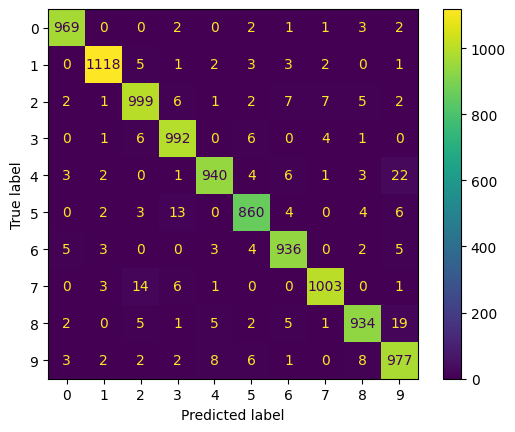

In [49]:
predictions = rf.predict(test_features)
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(test_labels, predictions)

In [112]:
pca = sklearn.decomposition.PCA(n_components = 128, random_state = 42)
train_features_reduced = pca.fit_transform(train_features_scaled)
print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
print([ round(x, 3) for x in pca.explained_variance_ratio_ ])
test_features_reduced = pca.transform(test_features_scaled)

Explained variance 0.96
[0.387, 0.14, 0.054, 0.045, 0.034, 0.026, 0.023, 0.018, 0.014, 0.011, 0.01, 0.01, 0.009, 0.008, 0.007, 0.007, 0.006, 0.006, 0.006, 0.005, 0.005, 0.005, 0.004, 0.004, 0.004, 0.004, 0.004, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [114]:
rf_reduced = sklearn.ensemble.RandomForestClassifier(n_jobs = -1, n_estimators = 1000)
rf_reduced.fit(train_features_reduced, train_labels)
print(rf_reduced.score(test_features_reduced, test_labels))

0.9398


In [113]:
rf = sklearn.neighbors.KNeighborsClassifier(n_jobs = -1, n_neighbors = 10)
rf.fit(train_features_reduced, train_labels)
print(rf.score(test_features_reduced, test_labels))

0.9401


In [34]:
umap_ = umap.UMAP(n_components = 8, n_jobs = -1)
train_features_reduced = umap_.fit_transform(train_features)
test_features_reduced = umap_.transform(test_features)

In [38]:
rf_reduced = sklearn.ensemble.RandomForestClassifier(n_jobs = -1, n_estimators = 1000)
rf_reduced.fit(train_features_reduced, train_labels)
print(rf_reduced.score(test_features_reduced, test_labels))

0.4565


In [41]:
rf = sklearn.neighbors.KNeighborsClassifier(n_jobs = -1, n_neighbors = 1000)
rf.fit(train_features_reduced, train_labels)
print(rf.score(test_features_reduced, test_labels))

0.4196


In [130]:
import torch
import random
import sklearn.preprocessing

RANDOM_STATE = 42
def set_random_seed(seed):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_random_seed(RANDOM_STATE)

device = torch.device("cuda")

# sc = sklearn.preprocessing.StandardScaler()
# train_features_scaled = sc.fit_transform(train_features)
# test_features_scaled = sc.fit_transform(test_features)

train_ds = torch.utils.data.TensorDataset(
    torch.tensor(train_features_reduced, dtype = torch.float),
    torch.tensor(train_labels, dtype = torch.long)
)

test_ds = torch.utils.data.TensorDataset(
    torch.tensor(test_features_reduced, dtype = torch.float),
    torch.tensor(test_labels, dtype = torch.long)
)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size = 1024, shuffle = True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = 1024, shuffle = False)

model = torch.nn.Sequential(
    torch.nn.Linear(train_features_reduced.shape[1], 128), torch.nn.BatchNorm1d(128), torch.nn.GELU(),
    torch.nn.Linear(128, 64), torch.nn.BatchNorm1d(64), torch.nn.GELU(),
    torch.nn.Linear(64, 32), torch.nn.BatchNorm1d(32), torch.nn.GELU(),
    torch.nn.Linear(32, 10)
).to(device)

optimizer = torch.optim.AdamW(
    params = model.parameters(),
    lr = 5e-4
)

for epoch in range(50):
    model.train()
    for (X, y) in train_dl:
        optimizer.zero_grad()
        pred = model(X.to(device))
        loss = torch.nn.functional.cross_entropy(pred, y.to(device), reduction = 'sum')
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        model.eval()
        preds = [ ]
        Y = [ ]
        for batch_x, batch_y in test_dl:
            preds.extend(torch.argmax(model(batch_x.to(device)), axis = 1).cpu())
            Y.extend(batch_y)
        accuracy = sklearn.metrics.accuracy_score(Y, preds)

    print(f"epoch {epoch}: loss = {loss.item()}, acc = {accuracy}")

epoch 0: loss = 644.3302001953125, acc = 0.893
epoch 1: loss = 394.3129577636719, acc = 0.9439
epoch 2: loss = 262.9677429199219, acc = 0.9592
epoch 3: loss = 171.90731811523438, acc = 0.9674
epoch 4: loss = 107.68948364257812, acc = 0.9712
epoch 5: loss = 105.65052032470703, acc = 0.9739
epoch 6: loss = 81.82074737548828, acc = 0.9753
epoch 7: loss = 83.57513427734375, acc = 0.9752
epoch 8: loss = 74.81822204589844, acc = 0.9752
epoch 9: loss = 48.3697624206543, acc = 0.9777
epoch 10: loss = 53.89626693725586, acc = 0.978
epoch 11: loss = 47.23657989501953, acc = 0.9786
epoch 12: loss = 35.1957893371582, acc = 0.9785
epoch 13: loss = 33.75276565551758, acc = 0.9787
epoch 14: loss = 37.895999908447266, acc = 0.9794
epoch 15: loss = 30.127429962158203, acc = 0.9788
epoch 16: loss = 26.396818161010742, acc = 0.9783
epoch 17: loss = 34.181922912597656, acc = 0.9794
epoch 18: loss = 20.302532196044922, acc = 0.9795
epoch 19: loss = 23.003026962280273, acc = 0.9794
epoch 20: loss = 11.87038

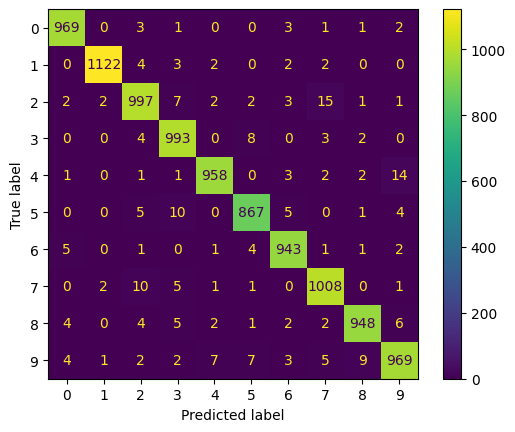

In [131]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(test_labels, numpy.array(preds))

In [90]:
rf = sklearn.neighbors.KNeighborsClassifier(n_jobs = -1, n_neighbors = 1)
rf.fit(train_features_scaled, train_labels)
print(rf.score(test_features_scaled, test_labels))

0.9448


In [16]:
def calculate_images(diagrams: numpy.ndarray, N: int = 49000):
    images = [ ]
    for i in range(0, len(diagrams), N):
        print(f'Calculating {i} - {i + N}')
        hk = gtda.diagrams.PersistenceImage(sigma = 1.6, n_jobs = -1)
        images.append(
            hk.fit_transform(diagrams[i:i + N])
        )
    return numpy.concatenate(images, axis = 0)

In [22]:
# train_filtration_pis = calculate_images(train_filtration_diagrams[:49000])
# numpy.save("4__train_filtration_pis.npy", train_filtration_pis)

train_filtration_pis = numpy.load("4__train_filtration_pis.npy")
train_filtration_pis.shape

(49000, 2, 100, 100)

In [24]:
test_filtration_pis = calculate_images(test_filtration_diagrams[:4900])
numpy.save("4__test_filtration_pis.npy", test_filtration_pis)

test_filtration_pis = numpy.load("4__test_filtration_pis.npy")
test_filtration_pis.shape

Calculating 0 - 49000


(4900, 2, 100, 100)

In [31]:
def make_images(filtration_pis: numpy.ndarray):
    images = [ ]
    for img_idx in tqdm.trange(len(filtration_pis) // 49, desc = 'combine images'):
        idx1 = 49 * img_idx
        idx2 = 49 * (img_idx + 1)
        images.append(numpy.concatenate(filtration_pis[idx1:idx2], axis = 0))

    return numpy.array(images)

train_images = make_images(train_filtration_pis)
test_images = make_images(test_filtration_pis)

combine images: 100%|██████████| 100/100 [00:00<00:00, 260.12it/s]


In [60]:
import torch
import random

RANDOM_STATE = 42
def set_random_seed(seed):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_random_seed(RANDOM_STATE)

device = torch.device("cuda")

train_ds = torch.utils.data.TensorDataset(
    torch.tensor(train_images, dtype = torch.float),
    torch.tensor(train_labels[:1000], dtype = torch.long)
)

test_ds = torch.utils.data.TensorDataset(
    torch.tensor(test_images, dtype = torch.float),
    torch.tensor(test_labels[:100], dtype = torch.long)
)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size = 16, shuffle = True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = 16, shuffle = False)

model = torch.nn.Sequential(
    torch.nn.Conv2d(98, 98, kernel_size = 7), torch.nn.BatchNorm2d(98), torch.nn.GELU(), torch.nn.MaxPool2d(3, 3),
    torch.nn.Conv2d(98, 196, kernel_size = 5), torch.nn.BatchNorm2d(196), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(196, 394, kernel_size = 3, dilation = 2), torch.nn.BatchNorm2d(394), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),

    torch.nn.Flatten(), torch.nn.LazyLinear(1024), torch.nn.BatchNorm1d(1024), torch.nn.GELU(),
    torch.nn.Linear(1024, 200)
).to(device)

optimizer = torch.optim.AdamW(
    params = model.parameters(),
    lr = 1e-4
)

for epoch in range(63):
    model.train()
    for (X, y) in train_dl:
        optimizer.zero_grad()
        pred = model(X.to(device))
        loss = torch.nn.functional.cross_entropy(pred, y.to(device), reduction = 'sum')
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        model.eval()
        preds = [ ]
        Y = [ ]
        for batch_x, batch_y in test_dl:
            preds.extend(torch.argmax(model(batch_x.to(device)), axis = 1).cpu())
            Y.extend(batch_y)
        accuracy = sklearn.metrics.accuracy_score(Y, preds)

    print(f"epoch {epoch}: loss = {loss.item()}, acc = {accuracy}")

epoch 0: loss = 15.74434757232666, acc = 0.14
epoch 1: loss = 10.03386116027832, acc = 0.21
epoch 2: loss = 8.581578254699707, acc = 0.17
epoch 3: loss = 10.991872787475586, acc = 0.2
epoch 4: loss = 6.203951835632324, acc = 0.21
epoch 5: loss = 1.505049228668213, acc = 0.17
epoch 6: loss = 0.8678723573684692, acc = 0.21
epoch 7: loss = 0.9153925180435181, acc = 0.22
epoch 8: loss = 1.1510440111160278, acc = 0.2
epoch 9: loss = 2.201138734817505, acc = 0.23
epoch 10: loss = 1.2548195123672485, acc = 0.19
epoch 11: loss = 1.3541066646575928, acc = 0.21
epoch 12: loss = 0.372041791677475, acc = 0.22
epoch 13: loss = 0.13058283925056458, acc = 0.18
epoch 14: loss = 0.15174895524978638, acc = 0.19
epoch 15: loss = 1.630298376083374, acc = 0.15
epoch 16: loss = 0.19768336415290833, acc = 0.2
epoch 17: loss = 2.128767728805542, acc = 0.19


KeyboardInterrupt: 